## 🌽 Maize Crop challenge
The Maize Crop challenge is a competition that focuses on improving maize crop yield through innovative solutions. Participants are tasked with developing methods to enhance the growth and productivity of maize crops, addressing issues such as soil health, pest management, and climate resilience.

The dataset comprises labeled maize leaf images categorized into four classes: Blight, Common Rust, Gray Leaf Spot, and Healthy.

It includes train.csv, val.csv, and test.csv files. Each CSV contains ID (image filename), with label included in train and validation sets.

The training and validation images are stored in class-specific subdirectories, while the test set contains unlabeled images for prediction.

This structured format supports supervised learning, model validation, and final evaluation. All images are in .jpg or .JPG format, enabling deep learning pipelines to process disease features for accurate classification and diagnostic model development.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
import torchvision.models as models
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import os
from PIL import Image

In [2]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install rarfile

In [4]:
import rarfile
import os

# Define the path to your RAR file and the extraction directory
rar_file_path = '/content/drive/MyDrive/competitions/zindi_maize_challenge/crop pictures.rar'
extract_dir = './extracted_files'  # Or any directory you want to extract to

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

try:
    with rarfile.RarFile(rar_file_path, 'r') as rf:
        rf.extractall(extract_dir)
    print(f"Successfully extracted RAR file to {extract_dir}")
except rarfile.BadRarFile:
    print(f"Error: The file {rar_file_path} is not a valid RAR file.")
except FileNotFoundError:
    print(f"Error: The file {rar_file_path} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully extracted RAR file to ./extracted_files


In [5]:
# -----------------------
# 1. Data Preparation
# -----------------------
train_transform = transforms.Compose([
    transforms.Resize((384, 384)),  # EfficientNet-B4 input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



val_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Directories
train_dir = os.path.join("extracted_files", "crop pictures", "train")
val_dir = os.path.join("extracted_files", "crop pictures", "val")

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
val_data = datasets.ImageFolder(val_dir, transform=val_transform)

In [6]:
# Compute class weights for imbalanced dataset
from collections import Counter
class_counts = Counter(train_data.targets)
num_classes = len(train_data.classes)
class_weights = [1.0 / class_counts[i] for i in range(num_classes)]
class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")


In [7]:

# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"


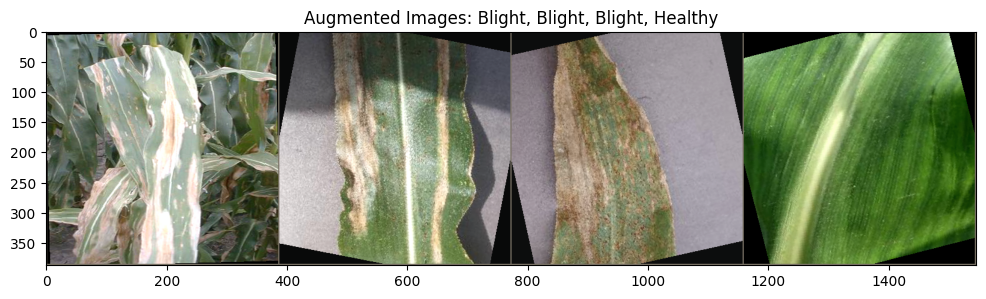

In [8]:
import torchvision

# Function to denormalize and show images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Re-create the train_data and train_loader with the new transform to ensure it's applied
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from the batch
out = torchvision.utils.make_grid(inputs)

# Get the class names for the titles
class_names = train_data.classes
titles = [class_names[x] for x in classes]

# Display the images
plt.figure(figsize=(12, 6))
imshow(out, title=f"Augmented Images: {', '.join(titles)}")

In [9]:
# -----------------------
# 2. Load Pre-trained EfficientNet-B4
# -----------------------
model = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False  # Freeze backbone

num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, num_classes)
)
model = model.to(device)

In [10]:
# -----------------------
# 3. Training Setup
# -----------------------
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.classifier.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Mixup function
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [11]:
# -----------------------
# 4. Training Loop with Early Stopping
# -----------------------
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_loss = float('inf')
patience, counter = 5, 0

for epoch in range(10):  # Increased epochs
    # Training
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        X, y_a, y_b, lam = mixup_data(X, y)
        optimizer.zero_grad()
        outputs = model(X)
        loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * y.size(0)
        train_correct += (outputs.argmax(1) == y).sum().item()
        train_total += y.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss += loss.item() * y.size(0)
            val_correct += (outputs.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

    scheduler.step()

Epoch 1, Train Loss: 0.7853, Train Acc: 0.5556, Val Loss: 0.3759, Val Acc: 0.8813
Epoch 2, Train Loss: 0.6237, Train Acc: 0.6270, Val Loss: 0.3003, Val Acc: 0.8987
Epoch 3, Train Loss: 0.6189, Train Acc: 0.6031, Val Loss: 0.2996, Val Acc: 0.8924
Epoch 4, Train Loss: 0.5570, Train Acc: 0.6352, Val Loss: 0.2714, Val Acc: 0.9193
Epoch 5, Train Loss: 0.5490, Train Acc: 0.6297, Val Loss: 0.2560, Val Acc: 0.9193
Epoch 6, Train Loss: 0.4923, Train Acc: 0.6498, Val Loss: 0.2470, Val Acc: 0.9225
Epoch 7, Train Loss: 0.5031, Train Acc: 0.6563, Val Loss: 0.2697, Val Acc: 0.9114
Epoch 8, Train Loss: 0.4771, Train Acc: 0.6471, Val Loss: 0.2399, Val Acc: 0.9177
Epoch 9, Train Loss: 0.4676, Train Acc: 0.6747, Val Loss: 0.2514, Val Acc: 0.9225
Epoch 10, Train Loss: 0.4533, Train Acc: 0.6727, Val Loss: 0.2466, Val Acc: 0.9177


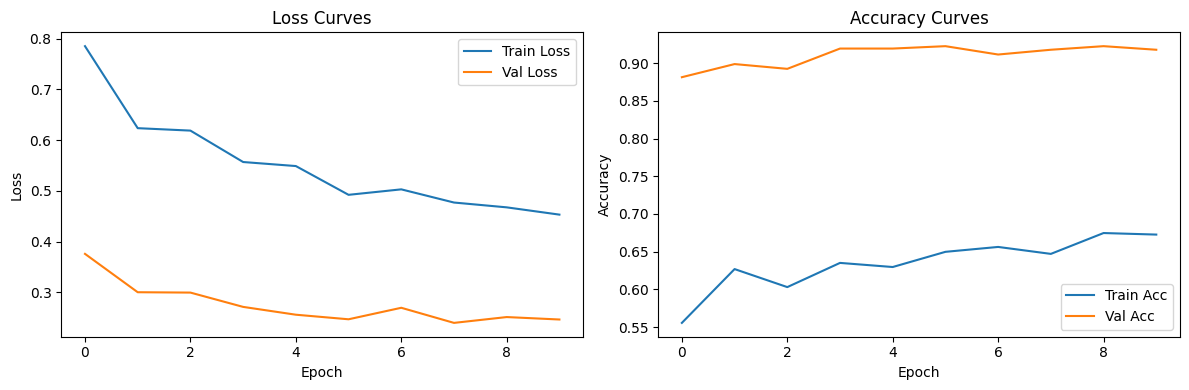

In [12]:
# -----------------------
# 5. Visualization
# -----------------------
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.show()

In [13]:
# -----------------------
# 6. Test Set Predictions
# -----------------------
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith(('.jpg', '.png', '.JPG'))] # Added .JPG

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(img_path)

test_dir = os.path.join("extracted_files", "crop pictures", "test") # Updated test_dir path

test_dataset = TestDataset(test_dir, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.load_state_dict(torch.load("best_model.pth"))
model.eval()
predictions_probs = [] # Store probabilities
image_names = []

with torch.no_grad():
    for X, names in test_loader:
        X = X.to(device)
        outputs = model(X)
        probs = torch.softmax(outputs, dim=1).cpu().numpy() # Get probabilities
        predictions_probs.extend(probs)
        image_names.extend(names)

In [14]:
# Map predictions to class names
class_names = train_data.classes

# Create submission CSV with probabilities
submission = pd.DataFrame(predictions_probs, columns=class_names) # Use probabilities and class names as columns
submission['ID'] = image_names # Add ID column
submission['ID'] = submission['ID'].apply(lambda x: os.path.splitext(x)[0]) # Remove file extension from ID

submission = submission[['ID'] + class_names] # Reorder columns

submission.to_csv("submission.csv", index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv


## Unfreeze backbone

Unfreeze some or all layers of the pre-trained EfficientNet-B4 backbone to allow for fine-tuning on the specific maize leaf dataset.

Iterate through the model layers and unfreeze the parameters of the last few layers for fine-tuning.




In [15]:
# Unfreeze the last few layers of the backbone for fine-tuning
# You can adjust the number of layers to unfreeze based on experimentation.
# A common approach is to unfreeze the last few convolutional blocks.

# Get the feature extractor part of EfficientNet-B4
features = model.features

# Determine the number of layers to unfreeze (e.g., the last 2 blocks)
# The number of blocks in EfficientNet-B4 is 16. Let's unfreeze the last 4 blocks.
num_blocks_to_unfreeze = 4

# Iterate through the feature blocks in reverse and unfreeze
# The blocks are typically in features[1] to features[8] for EfficientNet-B4,
# with features[0] being the initial conv layer and features[9] being the final conv layer before the classifier.
# Let's unfreeze the last `num_blocks_to_unfreeze` elements in the features module.
# We need to be careful with the indexing as the structure might vary slightly.
# Let's inspect the model structure to be precise.
# print(model)

# Based on the typical EfficientNet structure, the main blocks are in features[1] to features[8].
# Unfreezing the last 4 blocks means unfreezing features[5], features[6], features[7], features[8].
# We also want to unfreeze the final convolutional layer before the classifier, which is features[9].
# So, we will unfreeze features[5] through features[9].

# Let's confirm the number of modules in features
# print(len(features)) # This will show the number of top-level modules in features

# Assuming the structure is as described above (features[0] to features[9]),
# we will unfreeze features[9] and the last `num_blocks_to_unfreeze` blocks from features[1] to features[8].
# The blocks are typically at indices 1 through 8.
# The indices of the blocks to unfreeze will be from 8 down to 8 - num_blocks_to_unfreeze + 1.
# If num_blocks_to_unfreeze = 4, indices are 8, 7, 6, 5.
# We also unfreeze features[9].

# Let's define the indices to unfreeze explicitly for clarity.
unfreeze_indices = list(range(len(features) - num_blocks_to_unfreeze, len(features))) # Unfreeze the last num_blocks_to_unfreeze modules in features

# Additionally, unfreeze the final convolutional layer if it's not included in the blocks above.
# In EfficientNet, features[9] is often the final convolutional layer before the pooling and classifier.
if 9 not in unfreeze_indices:
    unfreeze_indices.append(9)

print(f"Unfreezing modules at indices: {unfreeze_indices}")

for i in unfreeze_indices:
    if i < len(features): # Ensure the index is valid
        for param in features[i].parameters():
            param.requires_grad = True

# Verify which layers are trainable
print("\nTrainable parameters after unfreezing:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)


Unfreezing modules at indices: [5, 6, 7, 8, 9]

Trainable parameters after unfreezing:
features.5.0.block.0.0.weight
features.5.0.block.0.1.weight
features.5.0.block.0.1.bias
features.5.0.block.1.0.weight
features.5.0.block.1.1.weight
features.5.0.block.1.1.bias
features.5.0.block.2.fc1.weight
features.5.0.block.2.fc1.bias
features.5.0.block.2.fc2.weight
features.5.0.block.2.fc2.bias
features.5.0.block.3.0.weight
features.5.0.block.3.1.weight
features.5.0.block.3.1.bias
features.5.1.block.0.0.weight
features.5.1.block.0.1.weight
features.5.1.block.0.1.bias
features.5.1.block.1.0.weight
features.5.1.block.1.1.weight
features.5.1.block.1.1.bias
features.5.1.block.2.fc1.weight
features.5.1.block.2.fc1.bias
features.5.1.block.2.fc2.weight
features.5.1.block.2.fc2.bias
features.5.1.block.3.0.weight
features.5.1.block.3.1.weight
features.5.1.block.3.1.bias
features.5.2.block.0.0.weight
features.5.2.block.0.1.weight
features.5.2.block.0.1.bias
features.5.2.block.1.0.weight
features.5.2.block.

## Adjust learning rate

* Experiment with different learning rates for the fine-tuned layers and the newly added classifier layers.

* Define a new optimizer that includes parameters from both the unfrozen backbone layers and the newly added classifier layers with potentially different learning rates.



In [16]:
# Define different learning rates for different parameter groups
classifier_lr = 1e-3  # Learning rate for the newly added classifier
backbone_lr = 1e-4    # Smaller learning rate for the unfrozen backbone layers

optimizer = optim.AdamW([
    {'params': model.classifier.parameters(), 'lr': classifier_lr},
    {'params': [param for name, param in model.named_parameters() if param.requires_grad and 'classifier' not in name], 'lr': backbone_lr, 'weight_decay': 1e-2}
], lr=classifier_lr, weight_decay=1e-2) # A base learning rate is required but will be overridden by parameter groups

# The scheduler should now operate on this new optimizer
scheduler = CosineAnnealingLR(optimizer, T_max=10)

print("Optimizer configured with different learning rates for classifier and backbone.")

Optimizer configured with different learning rates for classifier and backbone.


## Increase training epochs

* Increase training epochs to allow for better convergence, especially after unfreezing layers.
* Modify the training loop to use a larger number of epochs and ensure the learning rate scheduler is updated accordingly.




In [17]:
# -----------------------
# 4. Training Loop with Early Stopping (Increased Epochs)
# -----------------------
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_loss = float('inf')
patience, counter = 7, 0  # Increased patience slightly
num_epochs = 25  # Increased epochs to 25

# Re-initialize the scheduler with the new number of epochs
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        X, y_a, y_b, lam = mixup_data(X, y)
        optimizer.zero_grad()
        outputs = model(X)
        loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * y.size(0)
        train_correct += (outputs.argmax(1) == y).sum().item()
        train_total += y.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss += loss.item() * y.size(0)
            val_correct += (outputs.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    scheduler.step()


Epoch 1/25, Train Loss: 0.4636, Train Acc: 0.6631, Val Loss: 0.2091, Val Acc: 0.9351
Epoch 2/25, Train Loss: 0.4214, Train Acc: 0.6720, Val Loss: 0.1971, Val Acc: 0.9335
Epoch 3/25, Train Loss: 0.3990, Train Acc: 0.6846, Val Loss: 0.1961, Val Acc: 0.9430
Epoch 4/25, Train Loss: 0.3469, Train Acc: 0.6932, Val Loss: 0.1784, Val Acc: 0.9478
Epoch 5/25, Train Loss: 0.3283, Train Acc: 0.6867, Val Loss: 0.1747, Val Acc: 0.9383
Epoch 6/25, Train Loss: 0.3219, Train Acc: 0.7123, Val Loss: 0.1525, Val Acc: 0.9541
Epoch 7/25, Train Loss: 0.3059, Train Acc: 0.7051, Val Loss: 0.1650, Val Acc: 0.9573
Epoch 8/25, Train Loss: 0.3038, Train Acc: 0.7075, Val Loss: 0.1725, Val Acc: 0.9589
Epoch 9/25, Train Loss: 0.2725, Train Acc: 0.7092, Val Loss: 0.1511, Val Acc: 0.9604
Epoch 10/25, Train Loss: 0.2671, Train Acc: 0.7116, Val Loss: 0.1739, Val Acc: 0.9589
Epoch 11/25, Train Loss: 0.2594, Train Acc: 0.7143, Val Loss: 0.1829, Val Acc: 0.9573
Epoch 12/25, Train Loss: 0.2321, Train Acc: 0.7266, Val Loss: 0

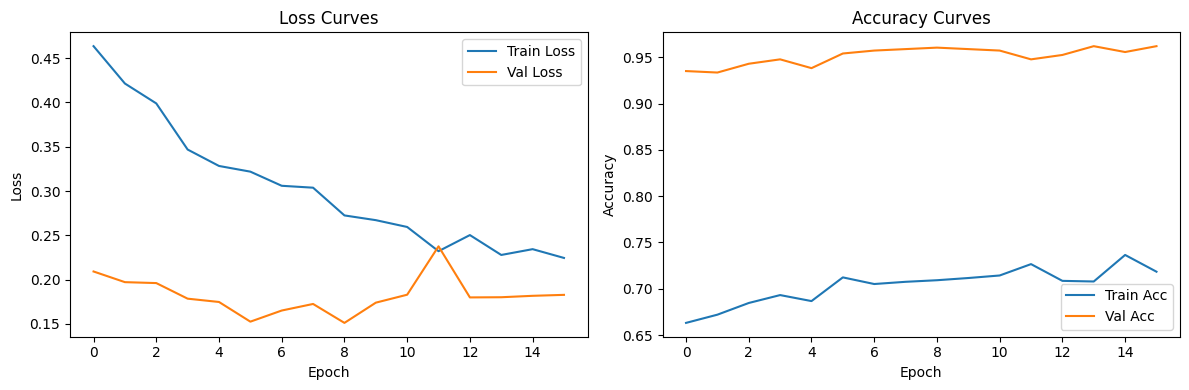

In [18]:
# -----------------------
# 5. Visualization (after increased epochs)
# -----------------------
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.show()

In [19]:
# -----------------------
# 6. Test Set Predictions (after increased epochs)
# -----------------------
# Re-load the best model state dictionary saved during training
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
predictions_probs = [] # Store probabilities
image_names = []

# Assuming test_loader is already defined from previous cells
with torch.no_grad():
    for X, names in test_loader:
        X = X.to(device)
        outputs = model(X)
        probs = torch.softmax(outputs, dim=1).cpu().numpy() # Get probabilities
        predictions_probs.extend(probs)
        image_names.extend(names)

# Map predictions to class names (assuming train_data.classes is still available)
class_names = train_data.classes

# Create submission CSV with probabilities
submission = pd.DataFrame(predictions_probs, columns=class_names) # Use probabilities and class names as columns
submission['ID'] = image_names # Add ID column
submission['ID'] = submission['ID'].apply(lambda x: os.path.splitext(x)[0]) # Remove file extension from ID

submission = submission[['ID'] + class_names] # Reorder columns

submission.to_csv("submission_increased_epochs.csv", index=False) # Save with a new name
print("Submission file created: submission_increased_epochs.csv")

Submission file created: submission_increased_epochs.csv
